GP Regression with GPflow
--

*James Hensman, 2015, 2016*

GP regression (with Gaussian noise) is the most straightforward GP model in GPflow. Because of the conjugacy of the latent process and the noise, the marginal likelihood $p(\mathbf y\,|\,\theta)$ can be computed exactly.

This notebook shows how to build a GPR model, estimate the parameters $\theta$ by both maximum likelihood and MCMC. 

In [1]:
import sys

In [2]:
sys.path.append('../../')

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

/home/keisukefujii/anaconda2/envs/GPflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
import GPflow
print GPflow.__file__

../../GPflow/__init__.pyc


In [5]:
reload(GPflow)

<module 'GPflow' from '../../GPflow/__init__.pyc'>

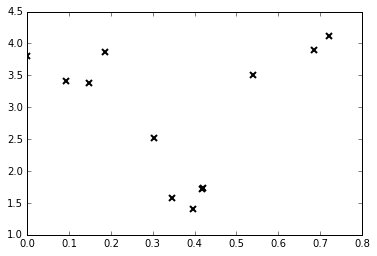

In [6]:
# build a very simple data set:
np.random.seed(1)
N = 12
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
plt.figure()
plt.plot(X, Y, 'kx', mew=2)

Maximum Likelihood estimation
--

In [7]:
#build the GPR object
k = GPflow.kernels.Matern52(1)
meanf = GPflow.mean_functions.Linear(1,0)
m = GPflow.gpr.GPR(X, Y, k, meanf)
m.likelihood.variance = 0.01

In [8]:
print "Here are the parameters before optimization"
m

Here are the parameters before optimization


Name,values,prior,constraint
model.mean_function.b,[ 0.],None,(none)
model.mean_function.A,[[ 1.]],None,(none)
model.kern.variance,[ 1.],None,+ve
model.kern.lengthscales,[ 1.],None,+ve
model.likelihood.variance,[ 0.01],None,+ve


In [9]:
m.optimize()
print "Here are the parameters after optimization"
m

compiling tensorflow function...
done
optimization terminated, setting model state
Here are the parameters after optimization


Name,values,prior,constraint
model.mean_function.b,[ 3.25050611],None,(none)
model.mean_function.A,[[ 0.37110123]],None,(none)
model.kern.variance,[ 0.79209109],None,+ve
model.kern.lengthscales,[ 0.10131151],None,+ve
model.likelihood.variance,[ 0.00037948],None,+ve


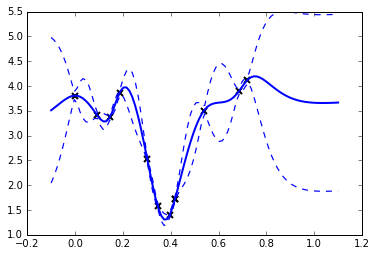

In [10]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)


In [11]:
m._needs_recompile

False

In [12]:
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.3 + 3
m.update_data(X, Y)

In [13]:
m._needs_recompile

False

In [14]:
m.optimize()
print "Here are the parameters after optimization"
m

optimization terminated, setting model state
Here are the parameters after optimization


Name,values,prior,constraint
model.mean_function.b,[ 3.20761841],None,(none)
model.mean_function.A,[[ 0.471915]],None,(none)
model.kern.variance,[ 0.96036722],None,+ve
model.kern.lengthscales,[ 0.07166942],None,+ve
model.likelihood.variance,[ 0.01045925],None,+ve


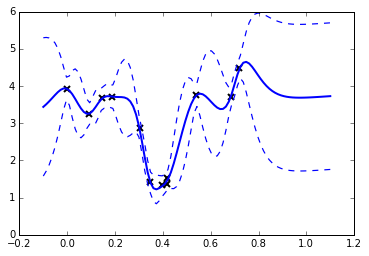

In [15]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)


In [14]:
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.3 + 3
m.get_data()[m.Y] = Y

In [15]:
m.kern.lengthscales = np.ones((1,))*0.01
m.likelihood.variance = 0.0001
m.kern.variance = np.ones((1,))
m.kern.lengthscales.fixed = True
#m.likelihood.variance.fixed = True

In [16]:
m.optimize()
print "Here are the parameters after optimization"
m

compiling tensorflow function...
done
optimization terminated, setting model state
Here are the parameters after optimization


Name,values,prior,constraint
model.kern.variance,[ 0.86611783],None,+ve
model.kern.lengthscales,[ 0.01],None,[FIXED]
model.mean_function.b,[ 2.94586893],None,(none)
model.mean_function.A,[[ 0.31773126]],None,(none)
model.likelihood.variance,[ 1.77326997e-09],None,+ve


In [17]:
m.kern.lengthscales = np.ones((1,))*0.1
m.likelihood.variance = 0.001
m.kern.variance = np.ones((1,))

In [18]:
m.optimize()
print "Here are the parameters after optimization"
m

optimization terminated, setting model state
Here are the parameters after optimization


Name,values,prior,constraint
model.kern.variance,[ 1.84262967],None,+ve
model.kern.lengthscales,[ 0.1],None,[FIXED]
model.mean_function.b,[ 3.18261858],None,(none)
model.mean_function.A,[[ 0.22484019]],None,(none)
model.likelihood.variance,[ 2.68141065e-12],None,+ve


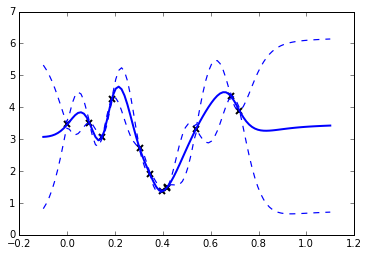

In [19]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)


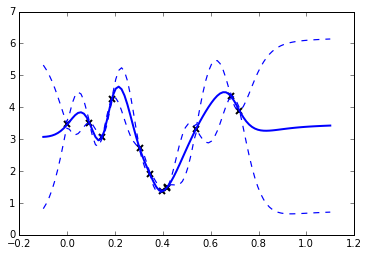

In [20]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_f(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)


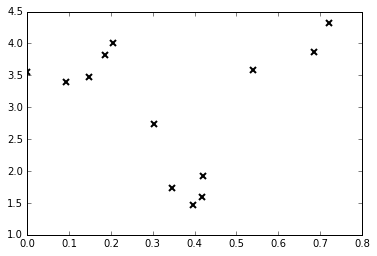

In [16]:
# build a very simple data set:
np.random.seed(1)
N = 13
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
plt.figure()
plt.plot(X, Y, 'kx', mew=2)

In [17]:
m.update_data(X, Y)

In [18]:
m.optimize()
print "Here are the parameters after optimization"
m

ValueError: Incompatible shapes for broadcasting: (13, 13) and (12, 12)

In [22]:
import tensorflow as tf

In [23]:
m.optimize(tf.train.GradientDescentOptimizer(learning_rate=0.001), max_iters=100)
print "Here are the parameters after optimization"
m

compiling tensorflow function...
done
Here are the parameters after optimization


Name,values,prior,constraint
model.kern.variance,[ 1.84257842],None,+ve
model.kern.lengthscales,[ 0.1],None,[FIXED]
model.mean_function.b,[ 3.18274583],None,(none)
model.mean_function.A,[[ 0.22487879]],None,(none)
model.likelihood.variance,[ 2.68141065e-12],None,+ve


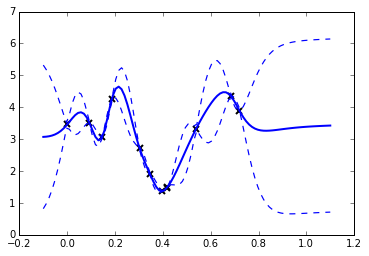

In [24]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)


MCMC
--
First, we'll set come priors on the kernel parameters, then we'll run mcmc and see how much posterior uncertainty there is in the parameters.

In [25]:
m.kern.lengthscales.fixed = False

In [26]:
#we'll choose rather arbitrary priors. 
m.kern.lengthscales.prior = GPflow.priors.Gamma(1., 1.)
m.kern.variance.prior = GPflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = GPflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = GPflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = GPflow.priors.Gaussian(0., 10.)
m

Name,values,prior,constraint
model.kern.variance,[ 1.84257842],"Ga([ 1.],[ 1.])",+ve
model.kern.lengthscales,[ 0.1],"Ga([ 1.],[ 1.])",+ve
model.mean_function.b,[ 3.18274583],"N([ 0.],[ 10.])",(none)
model.mean_function.A,[[ 0.22487879]],"N([ 0.],[ 10.])",(none)
model.likelihood.variance,[ 2.68141065e-12],"Ga([ 1.],[ 1.])",+ve


In [27]:
samples = m.sample(500, epsilon = 0.1, verbose=1)

compiling tensorflow function...
done


../../GPflow/hmc.py:97: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  samples[t/thin] = x
../../GPflow/hmc.py:101: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  samples[t/thin] = x_old


Iteration:  100 	 Acc Rate:  97.0 %
Iteration:  200 	 Acc Rate:  99.0 %
Iteration:  300 	 Acc Rate:  99.0 %
Iteration:  400 	 Acc Rate:  97.0 %
Iteration:  500 	 Acc Rate:  100.0 %


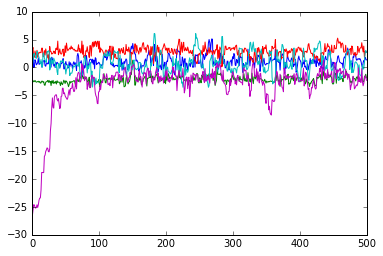

In [28]:
plt.figure()
plt.plot(samples)

/home/keisukefujii/anaconda2/envs/GPflow/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


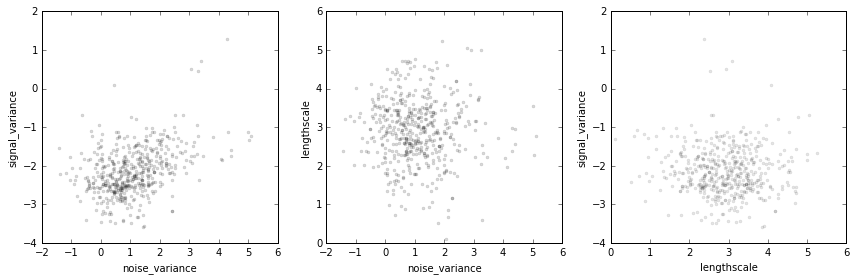

In [29]:
#Note. All these labels are wrong (or, most probably wrong). We need some machinery for labelling posterior samples!

f, axs = plt.subplots(1,3, figsize=(12,4), tight_layout=True)
axs[0].plot(samples[:,0], samples[:,1], 'k.', alpha = 0.15)
axs[0].set_xlabel('noise_variance')
axs[0].set_ylabel('signal_variance')
axs[1].plot(samples[:,0], samples[:,2], 'k.', alpha = 0.15)
axs[1].set_xlabel('noise_variance')
axs[1].set_ylabel('lengthscale')
axs[2].plot(samples[:,2], samples[:,1], 'k.', alpha = 0.1)
axs[2].set_xlabel('lengthscale')
axs[2].set_ylabel('signal_variance')

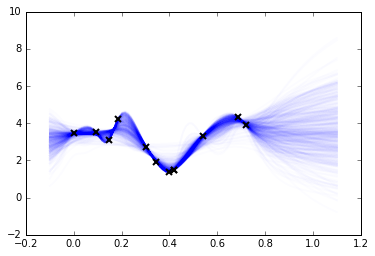

In [30]:
#an attempt to plot the function posterior
#Note that we should really sample the function values here, instead of just using the mean. 
#We are under-representing the uncertainty here. 
# TODO: get full_covariance of the predictions (predict_f only?)

plt.figure()

for s in samples:
    m.set_state(s)
    mean, _ = m.predict_y(xx)
    plt.plot(xx, mean, 'b', lw=2, alpha = 0.01)
    
plt.plot(X, Y, 'kx', mew=2)